<a href="https://colab.research.google.com/github/dduwa/ocular-disease-recognition/blob/main/Resnet50_Augmentation%2BOversampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
import os

from concurrent.futures import ThreadPoolExecutor

from ast import literal_eval
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
import seaborn as sns

# Access Dataset via Kaggle API
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem.

In [ ]:
from google.colab import files
uploaded = files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip

Saving kaggle.json to kaggle.json
100% 1.62G/1.62G [00:44<00:00, 40.0MB/s]
100% 1.62G/1.62G [00:44<00:00, 39.0MB/s]


# Loading the Dataset

In [ ]:
df_data = pd.read_csv('full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


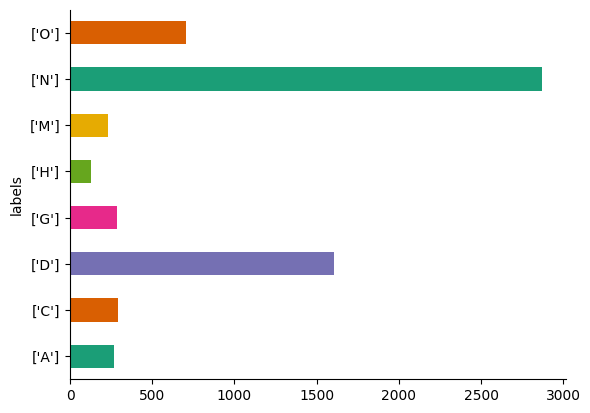

In [ ]:
# @title Using the target column for depicting data distribution

from matplotlib import pyplot as plt
import seaborn as sns
df_data.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Dataset Information

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

# Preparing the Data

In [ ]:
# Convert the string representation of one-hot encoded vectors to lists
df_data['target_list'] = df_data['target'].apply(literal_eval)

# Get the index of the '1' in each list which represents the class label
df_data['class_label'] = df_data['target_list'].apply(lambda x: np.argmax(x))

# Now you can use these class labels for stratified sampling
train_df, test_df = train_test_split(
    df_data,
    test_size=0.2,
    random_state=123,
    stratify=df_data['class_label']  # Use the class labels for stratification
)

# Do the same for splitting the training set into training and validation sets
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=123,
    stratify=train_df['class_label']  # Use the class labels for stratification
)

# Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H and M are minority classes since they have low image samples, causing class imbalance.

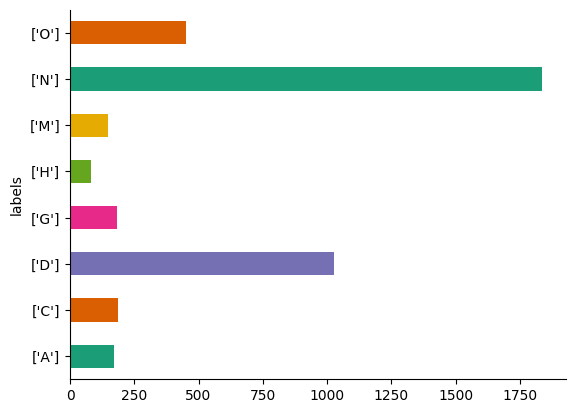

In [ ]:
# @title Distribution of Training Data

train_df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

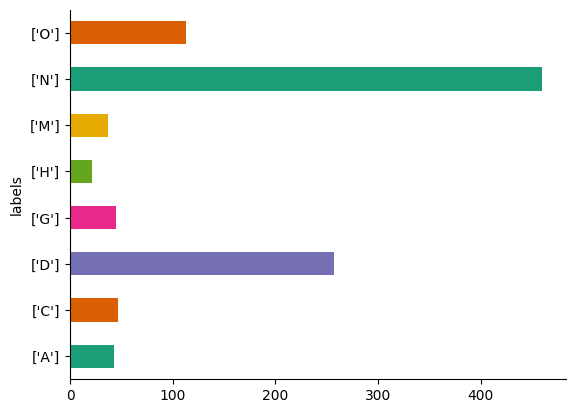

In [ ]:
# @title Distribution of Validation Data
val_df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

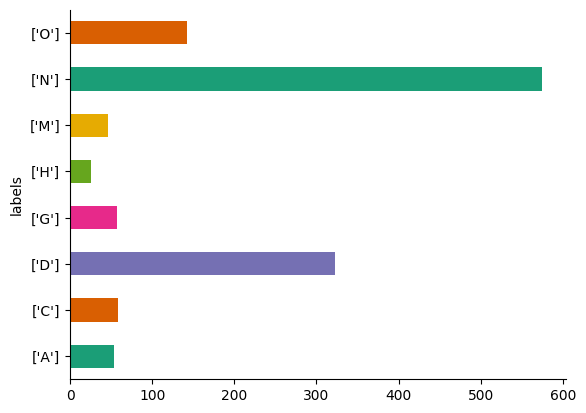

In [ ]:
# @title Distribution of Test Data
test_df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Assuming you have two DataFrames `train_df` and `val_df`
train_filenames = set(train_df['filename'].unique())
val_filenames = set(val_df['filename'].unique())

# Check for common elements
overlap = train_filenames.intersection(val_filenames)

# Print overlapping file names, if any
print(f"Overlapping files: {overlap}")

# Check if there's any overlap
if overlap:
    print(f"There are {len(overlap)} overlapping files.")
else:
    print("No overlapping files found.")



Overlapping files: set()
No overlapping files found.


In [ ]:
def oversample_dataset(dataset, labels, minority_classes_indices):
    # Create a dataset of just the minority classes
    minority_dataset = dataset.filter(lambda x, y: tf.reduce_any([y[idx] == 1 for idx in minority_classes_indices]))

    # Calculate the amount to oversample by (this is a simple example, you can use more complex logic)
    oversample_factor = 3  # Example factor by which to oversample the minority classes

    # Repeat the minority dataset
    minority_dataset = minority_dataset.repeat(oversample_factor)

    # Concatenate the minority dataset back with the original dataset
    return dataset.concatenate(minority_dataset)

In [ ]:
# Step 1: Calculate class distribution
class_distribution = df_data['target'].apply(lambda x: np.array(eval(x))).sum(axis=0)

# Step 2: Define a threshold to consider a class as minority
# This threshold could be a fixed number or a percentage of the dataset
threshold = class_distribution.mean()  # This is a simple example using the mean as a threshold

# Step 3: Identify minority classes
minority_classes = np.where(class_distribution < threshold)[0]

# Step 4: Update the apply_augmentation function to work with one-hot encoded labels
def apply_augmentation(image, one_hot_label, augment=False):
    # Convert the one_hot_label to a boolean tensor where 1s are True and 0s are False
    is_minority_class = tf.cast(one_hot_label, tf.bool)
    # Check if the label is one of the minority classes by reducing along the minority indices
    if augment and tf.reduce_any(tf.gather(is_minority_class, minority_classes)):
      # Randomly applied horizontal flip
      #image = tf.image.random_flip_left_right(image)
      # Randomly change image brightness
      image = tf.image.random_brightness(image, max_delta=0.1)
      # Randomly change image contrast
      image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
      # Randomly rotate the image
      image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
      # Random zoom
      if tf.random.uniform([]) > 0.5:
          image = tf.image.central_crop(image, central_fraction=tf.random.uniform([], 0.8, 1.0))
          image = tf.image.resize(image, [224, 224])
      # Random color adjustments
      image = tf.image.random_hue(image, max_delta=0.02)
    return image

In [ ]:
def file_exists(file_paths):
    # Filter out non-existing files
    return [file_path for file_path in file_paths if os.path.exists(file_path)]

def parse_image_and_label(image_path, label_string, augment=False):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    image = apply_augmentation(image, label, augment=augment)  # Conditionally apply augmentation
    return image, label

def load_and_prepare_dataset(df, images_dir, augment=False, shuffle=True, batch_size=32, oversample=False):
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Filter out filenames that do not exist
    valid_filenames = file_exists(filenames)
    valid_labels = labels[np.isin(filenames, valid_filenames)]  # Keep labels corresponding to the valid filenames

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((valid_filenames, valid_labels))
    dataset = dataset.map(lambda x, y: parse_image_and_label(x, y, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)

    if oversample:
      # Only call this for the training set
      dataset = oversample_dataset(dataset, valid_labels, minority_classes)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(valid_filenames))
    dataset = dataset.batch(batch_size)
    return dataset




In [ ]:
train_ds = load_and_prepare_dataset(train_df, 'preprocessed_images/', augment=True, shuffle=True, batch_size=64,  oversample=True)
val_ds = load_and_prepare_dataset(val_df, 'preprocessed_images/', augment=False, shuffle=False, batch_size=64)
test_ds = load_and_prepare_dataset(test_df, 'preprocessed_images/', augment=False, shuffle=False, batch_size=64)


In [ ]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))
print("size of test dataset: ", len(test_ds))

TypeError: The dataset length is unknown.

# Visualising the training and validation datasets




Training dataset
(64, 224, 224, 3)
(64, 8)


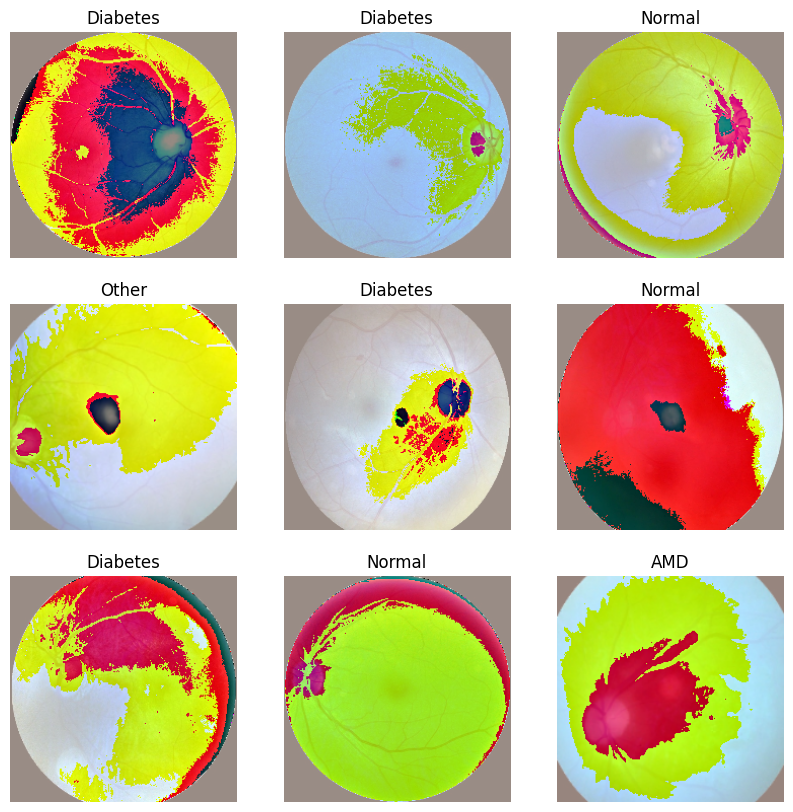

In [ ]:
print("Training dataset")
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])

    plt.axis("off")


Validation dataset
(64, 224, 224, 3)
(64, 8)


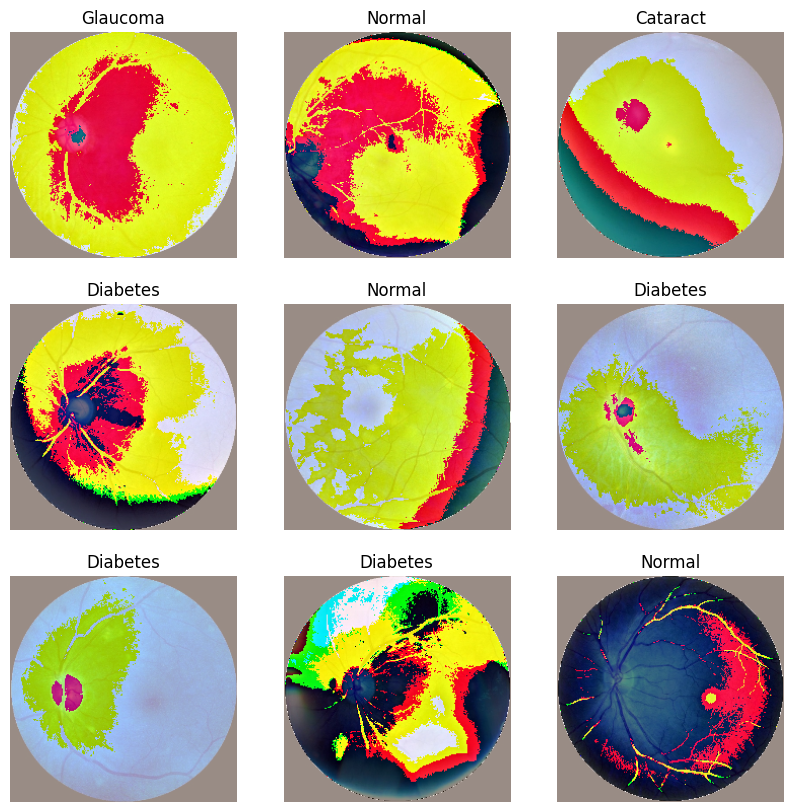

In [ ]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

In [ ]:
# Calculate class weights
def get_class_weights(labels):
    total_samples = len(labels)
    n_classes = len(labels[0])
    class_counts = np.zeros(n_classes)
    for label in labels:
        class_counts += label
    class_weights = total_samples / (n_classes * class_counts)
    return class_weights

# Get the labels from the training dataset
train_labels = []
for _, labels in train_ds:
    train_labels.append(labels.numpy())
train_labels = np.concatenate(train_labels)

# Assuming class_weights is the array returned by your function
class_weights_array = get_class_weights(train_labels)

# Convert this array into a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class weights dictionary:", class_weights_dict)

Class weights dictionary: {0: 0.5301482932288752, 1: 0.9398561507936508, 2: 1.323149441340782, 3: 1.2977739726027397, 4: 1.4139925373134328, 5: 2.923996913580247, 6: 1.662061403508772, 7: 0.5340332581736189}


# Training the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
checkpoint = ModelCheckpoint(filepath='best_model_Resnet50', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks = [early_stopping, checkpoint, reduce_lr]

In [ ]:
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_50_model = Sequential([
    pretrained_model,
    #Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)),
    Dense(256, activation='relu'),
    #BatchNormalization(),
    Dropout(0.6),
    Dense(8, activation='softmax')  # Final output layer for 8 classes
])


94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
resnet_50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 24114312 (91.99 MB)
Trainable params: 526600 (2.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
resnet_50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 50
# without class weights
history = resnet_50_model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
# with class weights
#history = resnet_50_model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, class_weight= class_weights_dict)

Epoch 1/50
    237/Unknown - 55s 158ms/step - loss: 1.6919 - accuracy: 0.3913
Epoch 1: val_loss improved from inf to 1.45558, saving model to best_model_Resnet50
237/237 [==============================] - 75s 244ms/step - loss: 1.6919 - accuracy: 0.3913 - val_loss: 1.4556 - val_accuracy: 0.4085 - lr: 1.0000e-04
Epoch 2/50
237/237 [==============================] - ETA: 0s - loss: 1.3873 - accuracy: 0.4890
Epoch 2: val_loss improved from 1.45558 to 1.35852, saving model to best_model_Resnet50
237/237 [==============================] - 66s 239ms/step - loss: 1.3873 - accuracy: 0.4890 - val_loss: 1.3585 - val_accuracy: 0.4814 - lr: 1.0000e-04
Epoch 3/50
237/237 [==============================] - ETA: 0s - loss: 1.2980 - accuracy: 0.5220
Epoch 3: val_loss improved from 1.35852 to 1.32915, saving model to best_model_Resnet50
237/237 [==============================] - 67s 243ms/step - loss: 1.2980 - accuracy: 0.5220 - val_loss: 1.3292 - val_accuracy: 0.4804 - lr: 1.0000e-04
Epoch 4/50
237/23

# Evaluating Model
- Model Accuracy
- Model Loss


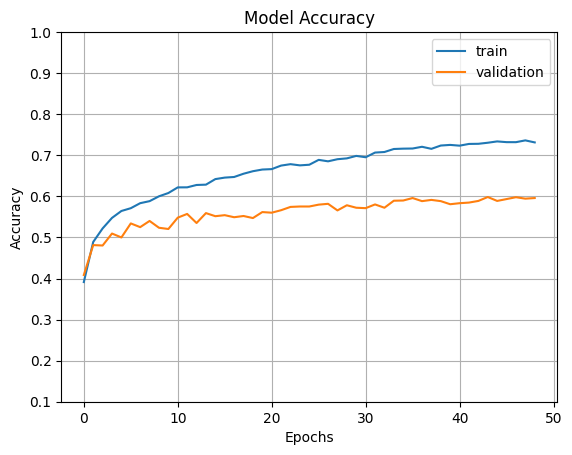

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

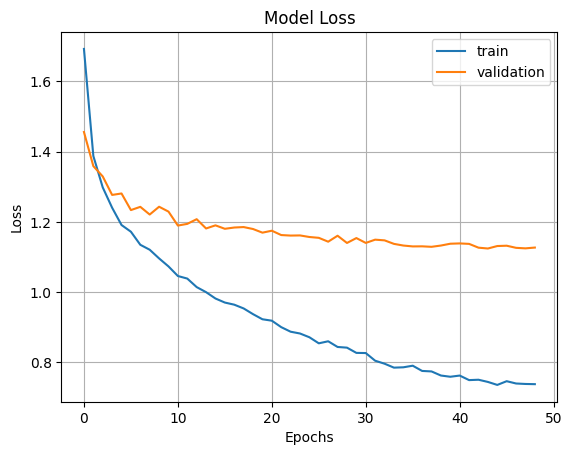

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
# Unfreeze the last 3 layers of the ResNet50 base model
for layer in pretrained_model.layers[-3:]:
    layer.trainable = True

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)  # A lower learning rate
resnet_50_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training
history = resnet_50_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)


Epoch 1/10
    237/Unknown - 48s 151ms/step - loss: 1.1103 - accuracy: 0.5832
Epoch 1: val_loss did not improve from 1.12413
237/237 [==============================] - 51s 164ms/step - loss: 1.1103 - accuracy: 0.5832 - val_loss: 1.1958 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 2/10
237/237 [==============================] - ETA: 0s - loss: 1.0993 - accuracy: 0.5852
Epoch 2: val_loss did not improve from 1.12413
237/237 [==============================] - 47s 160ms/step - loss: 1.0993 - accuracy: 0.5852 - val_loss: 1.2230 - val_accuracy: 0.5402 - lr: 0.0010
Epoch 3/10
237/237 [==============================] - ETA: 0s - loss: 1.0818 - accuracy: 0.5871
Epoch 3: val_loss did not improve from 1.12413
237/237 [==============================] - 48s 162ms/step - loss: 1.0818 - accuracy: 0.5871 - val_loss: 1.2276 - val_accuracy: 0.5487 - lr: 0.0010
Epoch 4/10
237/237 [==============================] - ETA: 0s - loss: 1.0813 - accuracy: 0.5920
Epoch 4: val_loss did not improve from 1.12413

Epoc

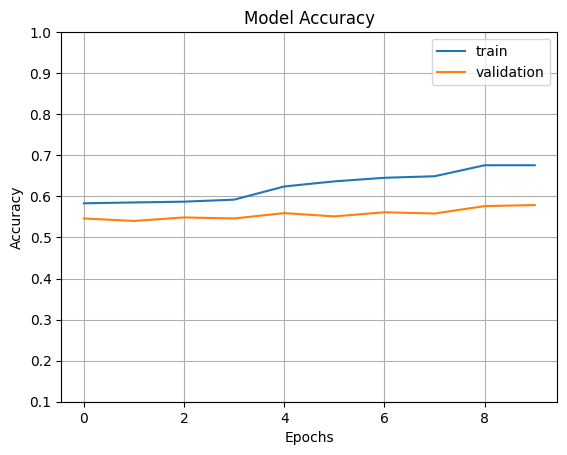

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

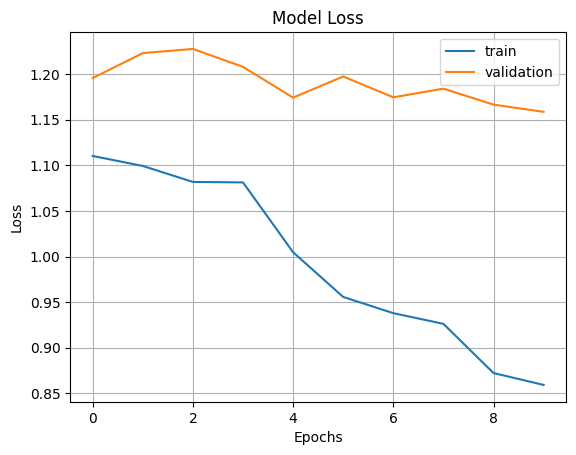

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

In [ ]:
test_ds.take(1)

# Evaluating the model on the test set
loss, accuracy = resnet_50_model.evaluate(test_ds)
print(f'Test accuracy: {round(accuracy * 100, 2)}%')

39/39 [==============================] - 3s 86ms/step - loss: 1.1300 - accuracy: 0.5912
Test accuracy: 59.12%


39/39 [==============================] - 3s 71ms/step - loss: 1.1300 - accuracy: 0.5912
Evaluation results: [1.1299567222595215, 0.5912379622459412]
39/39 [==============================] - 4s 67ms/step


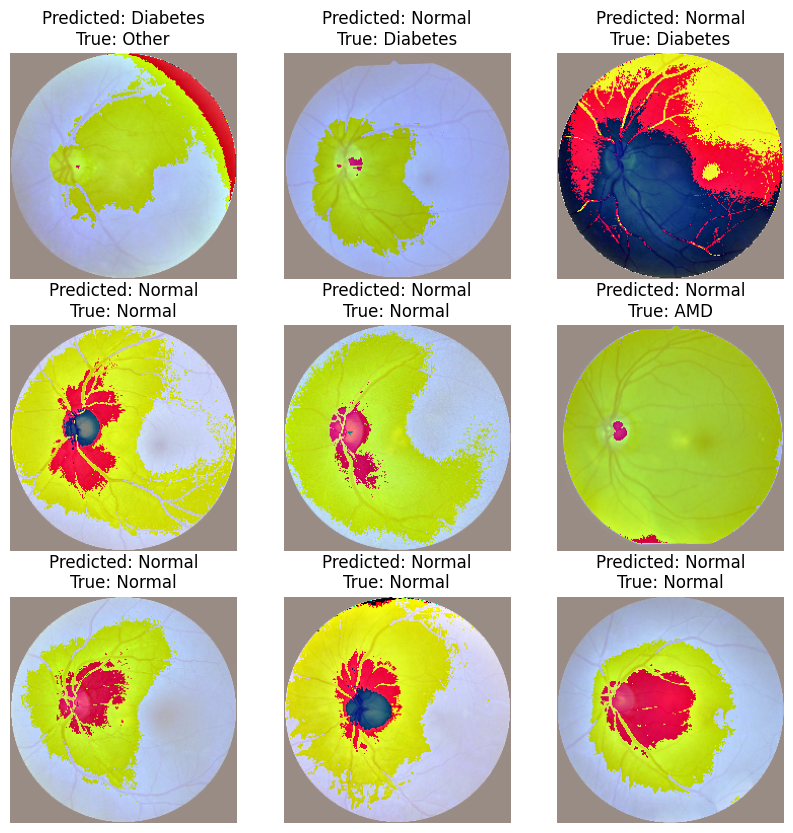

In [ ]:
# Evaluate the model on the test dataset
evaluation_results = resnet_50_model.evaluate(test_ds)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = resnet_50_model.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Define the number of images you want to display
num_images_to_display = 9

# Initialize lists to store the images and labels
display_images = []
display_labels = []

# Iterate over the dataset to collect images and labels
for images, labels in test_ds.unbatch().take(num_images_to_display):
    display_images.append(images)
    display_labels.append(labels)

# Now plot the images with predictions and true labels
plt.figure(figsize=(10, 10))
for i, image in enumerate(display_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    true_label = class_labels[np.argmax(display_labels[i].numpy())]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

# Evaluating Predictions

In [ ]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report

In [ ]:
for _, label in test_ds.unbatch().take(1):
    print("Unbatched label shape:", label.numpy().shape)
# Collect the true labels from the unbatched dataset
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# true_labels should now be a 2-dimensional array, you can verify by printing its shape
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

Unbatched label shape: (8,)
Shape of true_labels after vstack: (2488, 8)


In [ ]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)

                precision    recall  f1-score   support

        Normal       0.60      0.83      0.69      1121
      Diabetes       0.56      0.44      0.49       626
      Glaucoma       0.55      0.41      0.47       111
      Cataract       0.70      0.75      0.72       115
           AMD       0.70      0.28      0.40       106
  Hypertension       0.75      0.12      0.21        50
        Myopia       0.79      0.89      0.84        82
Other diseases       0.31      0.11      0.16       277

      accuracy                           0.59      2488
     macro avg       0.62      0.48      0.50      2488
  weighted avg       0.57      0.59      0.56      2488



 Balanced Accuracy Score

In [ ]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.4778


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)


In [ ]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.8443


Confusion Matrix

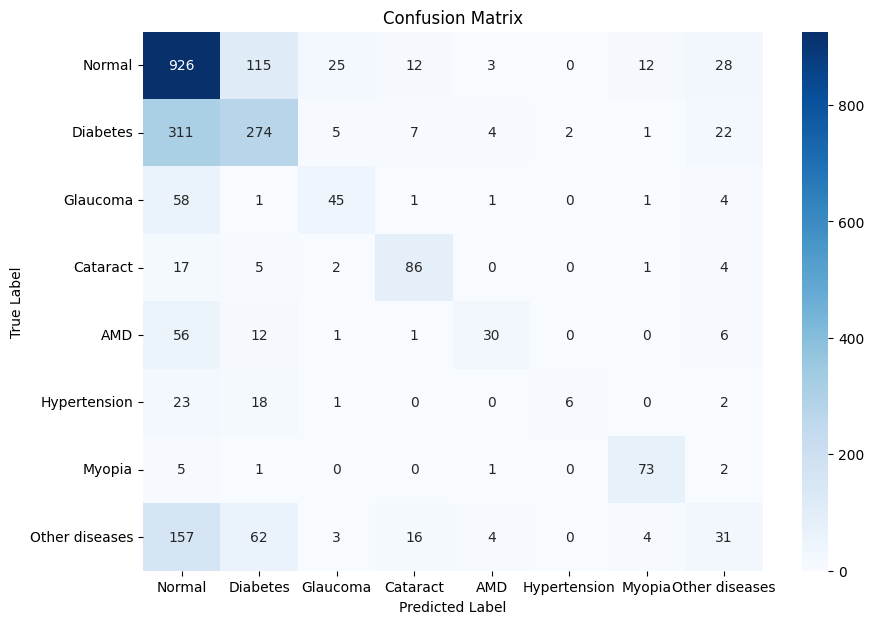

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Frequency of each class in top 3 predictions across all images


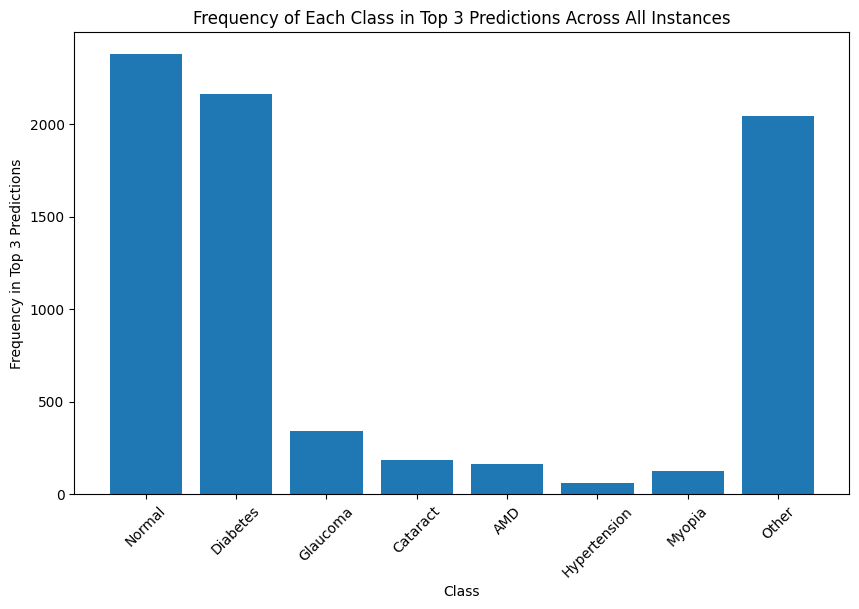

In [ ]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1



# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

# Explainable AI - SHAP, GradCAM and LIME

SHAP

---



In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
masker =  shap.maskers.Image("inpaint_telea", (224, 224, 3))
explainer = shap.Explainer(resnet_50_model, masker=masker)


In [ ]:



# Step 2: Compute SHAP values for a subset or individual samples
num_samples_to_explain = 10  # For example, explaining 10 samples
shap_values_list = []

for i in range(num_samples_to_explain):
    # Extract the i-th image data for explanation
    image_to_explain = unbatched_images[i:i+1]  # Keep the batch dimension for compatibility

    # Compute SHAP values for this image
    shap_values = explainer(image_to_explain)

    # Store the SHAP values
    shap_values_list.append(shap_values)

    # Normalize the specific image for visualization
    image_for_vis = images_for_visualization[i]

    # Visualize the SHAP values for this sample
    # Ensure the image data is in the expected range ([0, 255] for integers) and shape for `shap.image_plot`
    shap.image_plot(shap_values, image_for_vis)

In [ ]:
# Step 1: Unbatch the dataset and process both images and labels
unbatched_images = np.stack([x.numpy() for x, _ in test_ds.unbatch()])
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# Verify shapes
print("Shape of unbatched_images:", unbatched_images.shape)
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices (you've already done this)
true_classes = np.argmax(true_labels, axis=1)

# Step 2: Compute SHAP values for a subset or individual samples
# Note: Depending on the size of your data and model complexity, you may want to limit the number of samples
num_samples_to_explain = 10  # For example, explaining 10 samples

# Initialize a list to hold SHAP values for the chosen samples
shap_values_list = []



In [ ]:
for i in range(num_samples_to_explain):
    # Extract the i-th image data for explanation
    image_to_explain = unbatched_images[i:i+1]  # Keep the batch dimension for compatibility

    # Compute SHAP values for this image
    shap_values = explainer(image_to_explain)

    # Store the SHAP values
    shap_values_list.append(shap_values)

    # Optionally, visualize the SHAP values for this sample
    shap.image_plot(shap_values, -image_to_explain)